In [1]:
%load_ext autoreload

In [2]:
%autoreload 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import utilities as ut
from sklearn.model_selection import train_test_split

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
from featurewiz import FeatureWiz

ImportError: Dask's distributed scheduler is not installed.

Please either conda or pip install dask distributed:

  conda install dask distributed          # either conda install
  python -m pip install "dask[distributed]" --upgrade  # or python -m pip install

# Create train data


In [4]:
# Read and structure all the parquet files in the data folder
data_list = ut.read_data()

In [5]:
# Create a data processor object
Data = ut.DataProcessor(data_list)

In [6]:
# Create the formatted dataframe
df = Data.create_train_data()

<Axes: xlabel='date_forecast'>

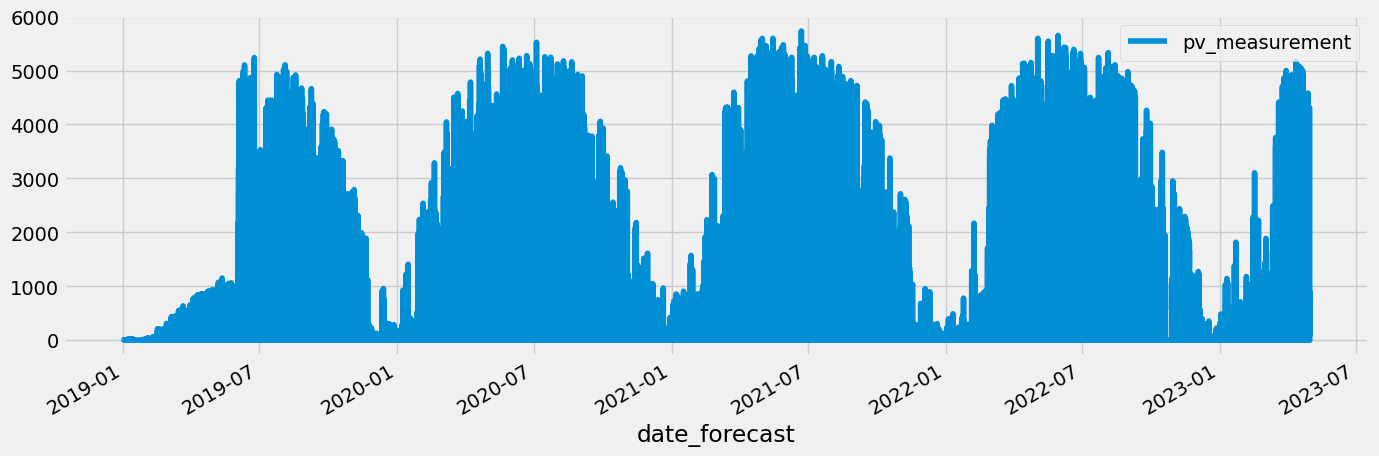

In [7]:
# plot db features column pv_measurement against the index iof the dataframe
df.plot(y='pv_measurement', figsize=(15, 5))

Seems like we are missing a lot of data in the first half of 2019

In [8]:
# slice df to only include from 2019-09-04 08:00:00 onwards (this is where we have data for all features)
df.sort_index(inplace=True)
df = df.loc['2019-09-04 08:00:00':]

<Axes: xlabel='date_forecast'>

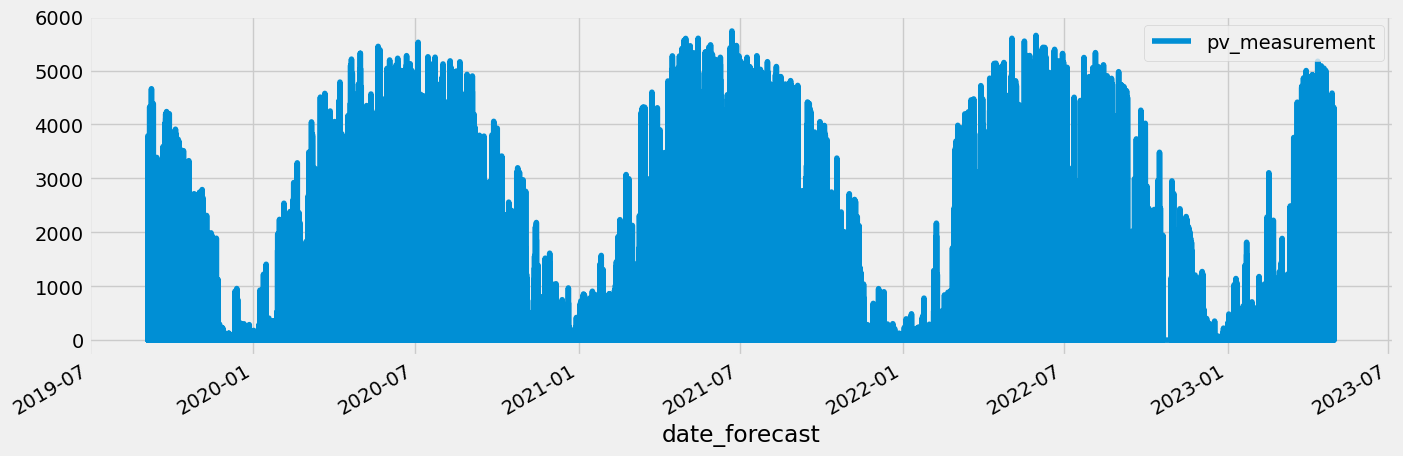

In [9]:
# createa add_lags function 
df.plot(y='pv_measurement', figsize=(15, 5))

## Feature Engineering

Trying to add some new features

In [10]:
# 1. Solar Exposure
df['solar_exposure'] = df['direct_rad:W'] + 0.2 * df['diffuse_rad:W']

# 2. Temperature Difference
df['temp_difference'] = df['t_1000hPa:K'] - df['dew_point_2m:K']

# 3. Cloudiness Duration
df['cloudiness_duration'] = df['total_cloud_cover:p'] * 24  # Assuming hourly data, so multiply by 24

# 4. Wind Speed at Different Altitudes
df['wind_speed_difference'] = df['wind_speed_10m:ms'] - df['wind_speed_w_1000hPa:ms']

# 5. Daylight Duration
df['daylight_duration'] = df['is_day:idx'].astype(int).groupby(df['day_of_month']).transform('sum')

# 6. Weather Conditions Indicator
df['weather_conditions'] = pd.cut(df['total_cloud_cover:p'], bins=[0, 0.2, 0.6, 1], labels=['clear', 'partly cloudy', 'overcast'])

# 7. Seasonal Indicator
df['season'] = pd.cut(df['month'], bins=[0, 3, 6, 9, 12], labels=['winter', 'spring', 'summer', 'fall'])

# 8. Interaction Terms
df['solar_temp_interaction'] = df['direct_rad:W'] * df['t_1000hPa:K']

# 9. Historical Averages
df['historical_avg_solar_rad'] = df['direct_rad:W'].rolling(window=30).mean()

In [27]:
X_test = ut.create_test_data()

AttributeError: module 'utilities' has no attribute 'create_test_data'

In [11]:
df.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,pv_measurement,solar_exposure,temp_difference,cloudiness_duration,wind_speed_difference,daylight_duration,weather_conditions,season,solar_temp_interaction,historical_avg_solar_rad
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-09-04 08:00:00,6.9,1.231,2103.100098,1166053.375,382.100006,2103.100098,0.0,278.600006,66.400002,226964.906250,...,570.1125,317.579987,4.399994,7.200000,1.0,1317,partly cloudy,summer,86116.898438,NaN
2019-09-04 08:00:00,6.8,1.226,2104.000000,1166048.250,382.100006,2104.000000,0.0,278.600006,66.400002,226962.703125,...,3786.2000,317.579987,4.399994,7.200000,1.0,1317,partly cloudy,summer,86116.898438,NaN
2019-09-04 08:00:00,6.7,1.223,2122.699951,1167217.875,382.500000,2122.699951,0.0,278.399994,66.099998,225542.296875,...,137.2000,318.720001,4.899994,7.200000,1.3,1317,partly cloudy,summer,86548.148438,NaN
2019-09-04 09:00:00,6.7,1.225,2476.500000,1559157.375,479.700012,2476.500000,0.0,278.399994,73.199997,251260.000000,...,542.5125,399.039978,5.800018,2066.399902,1.4,1317,NaN,summer,109246.484375,NaN
2019-09-04 09:00:00,6.7,1.220,2478.399902,1559161.250,479.700012,2478.399902,0.0,278.399994,73.199997,251256.593750,...,3400.7600,399.039978,5.800018,2066.399902,1.4,1317,NaN,summer,109246.484375,NaN


In [12]:
FEATURES = list(df.columns)

FEATURES.remove('pv_measurement')
FEATURES.remove('building') # this is a categorical feature that we will not use

TARGET = 'pv_measurement'

X_train = df[FEATURES]
y_train = df[TARGET]

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.8 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (84798, 53)
    Some column names had special characters which were removed...
#### Single_Label Re

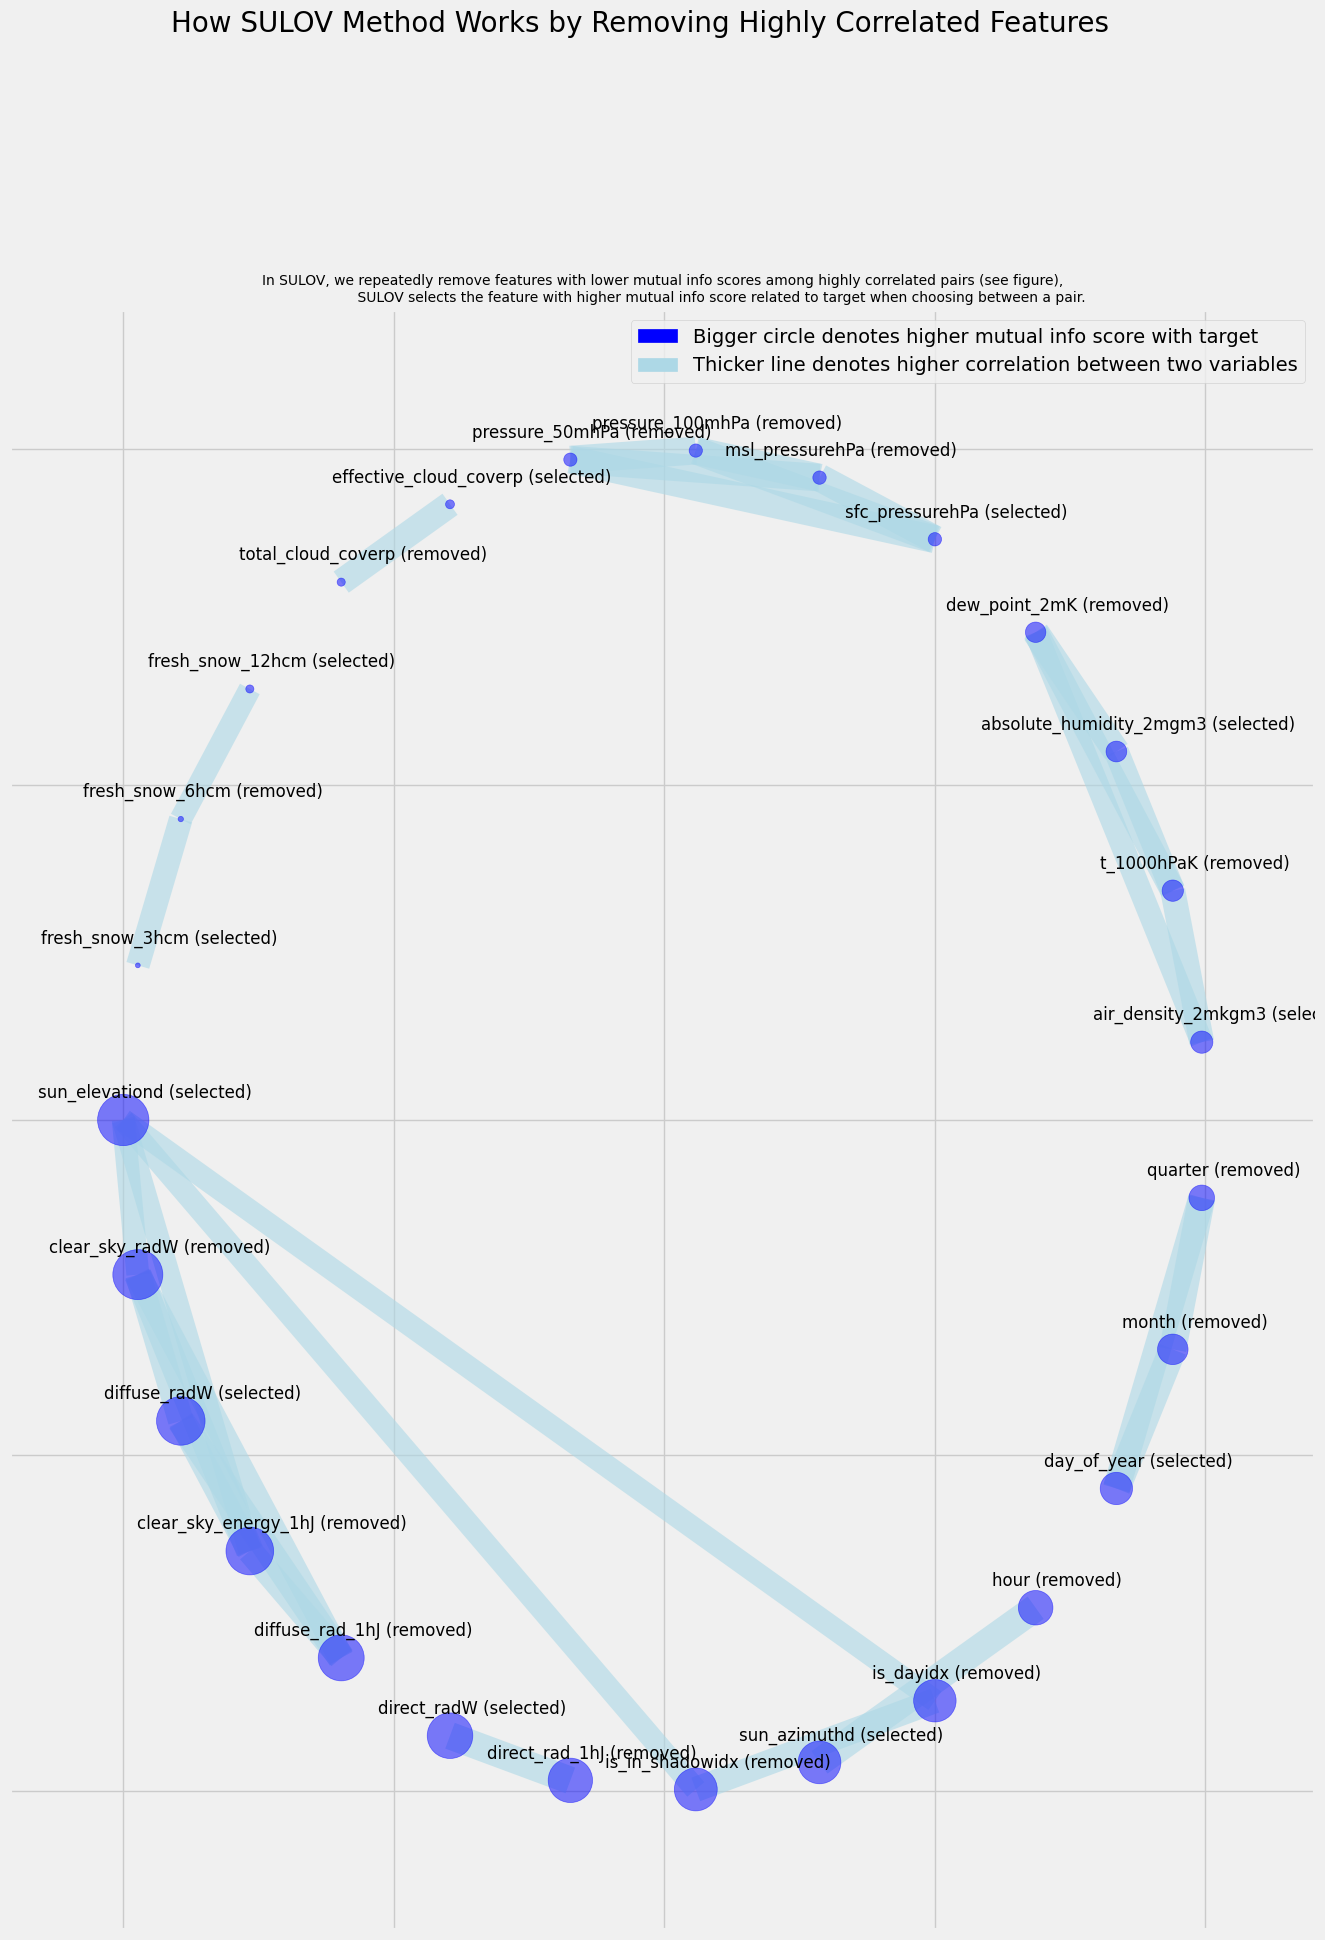

Time taken for SULOV method = 21 seconds
    Adding 0 categorical variables to reduced numeric variables  of 34
Finally 34 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 12 features per iteration...
    XGBoost version using 1.7.6 as tree method: hist
    Number of booster rounds = 100
        Selected: ['elevationm', 'direct_radW', 'diffuse_radW', 'sun_elevationd', 'sun_azimuthd', 'day_of_year', 'sfc_pressurehPa', 'wind_speed_u_10mms', 'absolute_humidity_2mgm3', 'cloud_base_aglm', 'day_of_month', 'ceiling_height_aglm']
            Time taken for regular XGBoost feature selection = 6 seconds
        Selected: ['direct_radW', 'visibilitym', 'sun

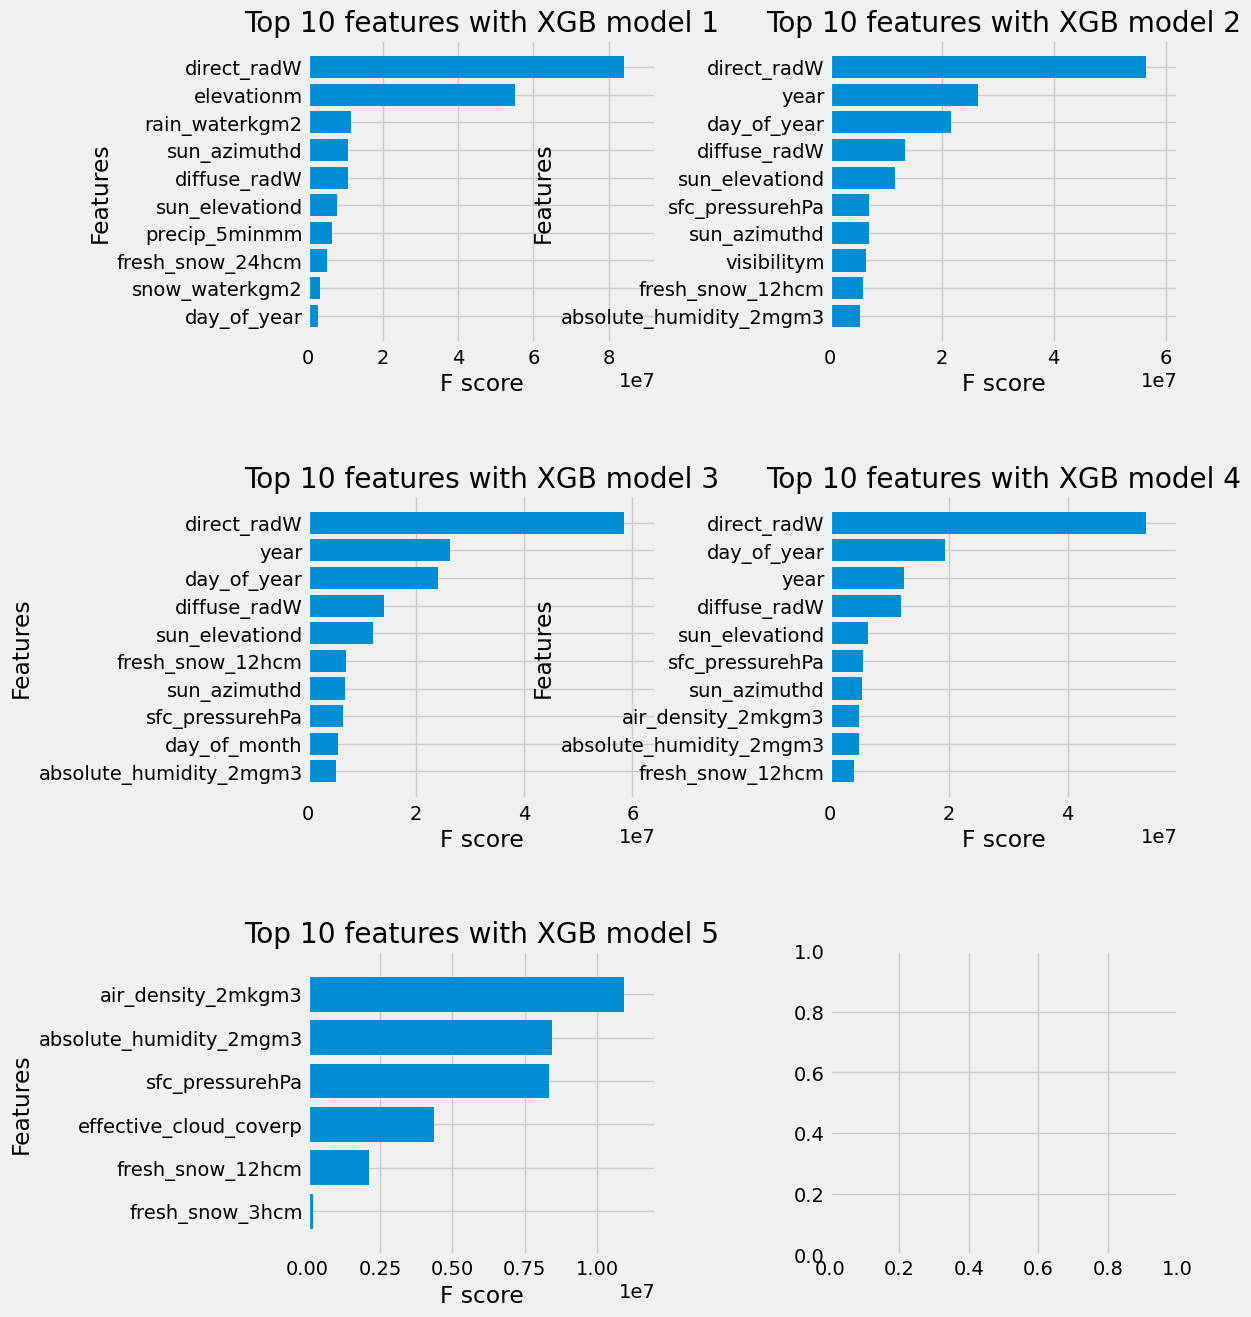

    Completed XGBoost feature selection in 2 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 20 important features:
['elevationm', 'direct_radW', 'diffuse_radW', 'sun_elevationd', 'sun_azimuthd', 'day_of_year', 'sfc_pressurehPa', 'wind_speed_u_10mms', 'absolute_humidity_2mgm3', 'cloud_base_aglm', 'day_of_month', 'ceiling_height_aglm', 'visibilitym', 'year', 'air_density_2mkgm3', 'relative_humidity_1000hPap', 'wind_speed_v_10mms', 'effective_cloud_coverp', 'fresh_snow_12hcm', 'fresh_snow_3hcm']
Total Time taken for featurewiz selection = 43 seconds
Output contains a list of 20 important features and a train dataframe
    Time taken to create entire pipeline = 43 second(s)


In [15]:
fwiz = FeatureWiz(corr_limit=0.80, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None, verbose=2)
X_train_selected = fwiz.fit_transform(X_train, y_train)
X_test_selected = fwiz.transform(X_test)
### get list of selected features ###
feats = fwiz.features  

In [16]:
X_test

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,day_of_week,quarter,month,year,day_of_year,day_of_month
date_forecast,,,,,,,,,,,,,,,,,,,,,
2023-05-01 00:00:00,4.4,1.286,912.700012,0.0,0.0,1041.199951,0.0,271.700012,0.0,0.0,...,2.2,3.4,-0.0,0,0,2,5,2023,121,1
2023-05-01 00:00:00,4.3,1.283,912.299988,0.0,0.0,1039.900024,0.0,271.700012,0.0,0.0,...,2.2,3.4,-0.0,0,0,2,5,2023,121,1
2023-05-01 00:00:00,4.2,1.286,NaN,0.0,0.0,1178.000000,0.0,271.100006,0.0,0.0,...,1.5,3.1,-0.0,0,0,2,5,2023,121,1
2023-05-01 00:15:00,4.3,1.287,912.700012,0.0,0.0,1054.800049,0.0,271.700012,0.0,0.0,...,2.1,3.4,-0.0,0,0,2,5,2023,121,1
2023-05-01 00:15:00,4.3,1.283,912.299988,0.0,0.0,1053.099976,0.0,271.700012,0.0,0.0,...,2.1,3.4,-0.0,0,0,2,5,2023,121,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 23:30:00,9.0,1.208,2015.599976,0.0,0.0,1405.500000,0.0,282.700012,0.0,0.0,...,1.6,-1.1,0.0,23,0,3,7,2023,184,3
2023-07-03 23:30:00,9.0,1.207,2015.000000,0.0,0.0,1408.599976,0.0,282.700012,0.0,0.0,...,1.6,-1.1,0.0,23,0,3,7,2023,184,3
2023-07-03 23:45:00,9.0,1.207,2014.900024,0.0,0.0,1343.599976,0.0,282.600006,0.0,0.0,...,1.6,-1.1,0.0,23,0,3,7,2023,184,3


In [13]:
X_test_selected.to_csv('X_test_selected.csv')
X_train_selected.to_csv('X_train_selected.csv')
y_train.to_csv('y_train.csv')

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_selected, y_train, train_size=0.90, random_state=42)

In [ ]:
valdiation_frame = pd.concat([X_test, Y_test], axis=1)
valdiation_frame.to_csv('validation_frame.csv')
training_frame = pd.concat([X_train, Y_train], axis=1)
training_frame.to_csv('training_frame.csv')